In [1]:
import os
import pandas as pd
import numpy as np
os.chdir('..\ModelExploration') 
import standardize
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
%matplotlib inline

In [41]:
data = pd.read_csv('../ModelExploration/ML_data.csv')
data.head()

,Type,AB,Site,Impurity,∆H (A-rich),∆H (B-rich),(+2/+1),(+1/0),(0/-1),(-1/-2),...,Therm_cond,Elec_cond,Heat_fusion,Heat_vap,Electronegativity,At_num,Period,Group,Valence,Ox_state
0,IV-IV,SiC,M_i_A,In,15.963,15.963,3.891,4.660,5.109,5.629,...,81.60,3.4,3.26,226.34,1.78,49,5,13,3,3
1,IV-IV,SiC,M_i_B,La,19.972,19.554,3.863,4.539,4.991,5.556,...,13.50,1.9,11.30,399.57,1.10,57,6,3,3,3
2,IV-IV,SiC,M_i_neut,Zn,7.157,7.157,3.206,4.244,4.734,5.363,...,116.00,16.9,7.38,115.30,1.65,30,4,12,2,2
3,IV-IV,SiC,M_i_B,Al,6.951,7.110,3.503,4.242,4.650,5.319,...,237.00,37.7,10.70,290.80,1.61,13,3,13,3,3
4,IV-IV,SiC,M_B,I,8.783,9.201,3.614,4.221,5.058,5.608,...,0.45,0.0,7.76,20.90,2.66,53,5,17,7,1


In [40]:
data[(data['∆H (A-rich)']>10) + (data['∆H (B-rich)']>10)]

C:\Users\xiang\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  op=op_str, alt_op=unsupported[op_str]


,Type,AB,Site,Impurity,∆H (A-rich),∆H (B-rich),(+2/+1),(+1/0),(0/-1),(-1/-2),...,Therm_cond,Elec_cond,Heat_fusion,Heat_vap,Electronegativity,At_num,Period,Group,Valence,Ox_state
0,IV-IV,SiC,M_i_A,In,15.963,15.963,3.891,4.660,5.109,5.629,...,81.60,3.4,3.26,226.34,1.78,49,5,13,3,3
1,IV-IV,SiC,M_i_B,La,19.972,19.554,3.863,4.539,4.991,5.556,...,13.50,1.9,11.30,399.57,1.10,57,6,3,3,3
6,III-V,BN,M_A,Pb,17.053,9.405,-0.954,4.167,5.413,6.755,...,35.30,4.8,4.77,177.90,2.33,82,6,14,4,2
8,III-V,AlN,M_i_B,Ca,12.449,14.825,3.086,4.097,4.989,5.718,...,200.00,31.3,8.53,154.67,1.00,20,4,2,2,2
10,III-V,AlN,M_i_neut,Si,11.129,14.190,2.969,4.003,4.726,5.517,...,148.00,0.0,50.20,359.00,1.90,14,3,14,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
789,IV-IV,SnC,M_i_A,I,14.807,15.560,-1.467,-1.407,-0.658,0.060,...,0.45,0.0,7.76,20.90,2.66,53,5,17,7,1
808,IV-IV,SnC,M_i_A,Se,10.598,14.083,-1.742,-1.625,-0.774,-0.393,...,2.04,8.0,5.54,26.32,2.55,34,4,16,6,4
812,IV-IV,SnC,M_B,Nb,10.669,10.150,-2.283,-1.641,-1.150,-0.272,...,53.70,6.6,26.90,690.10,1.60,41,5,5,5,5
837,IV-IV,SnC,M_A,Cs,7.297,13.112,-2.886,-2.012,-1.279,-0.834,...,35.90,5.3,2.09,67.74,0.79,55,6,1,1,1


In [42]:
len(data)

853

In [43]:
data_1 = data[data['Type']=='II-VI']
data_2 = data[data['Type']=='III-V']
data_3 = data[data['Type']=='IV-IV']

In [44]:
descriptors = list(data.columns[4:10])
descriptors

['∆H (A-rich)', '∆H (B-rich)', '(+2/+1)', '(+1/0)', '(0/-1)', '(-1/-2)']

In [45]:
outlier_fraction=0.1
classifiers = {
     'Angle-based Outlier Detector (ABOD)'   : ABOD(contamination=outlier_fraction),
     'K Nearest Neighbors (KNN)' :  KNN(contamination=outlier_fraction)
}

In [64]:
input_matrix = np.array(data_3[descriptors])
#input_matrix = input_matrix.reshape(-1,1)
input_matrix

array([[15.963, 15.963,  3.891,  4.66 ,  5.109,  5.629],
       [19.972, 19.554,  3.863,  4.539,  4.991,  5.556],
       [ 7.157,  7.157,  3.206,  4.244,  4.734,  5.363],
       ...,
       [-1.598,  0.946, -2.75 , -2.404, -1.048, -0.521],
       [ 1.462,  7.277, -2.902, -2.44 , -0.73 , -0.075],
       [ 3.072,  3.825, -3.066, -2.641, -2.32 , -1.833]])

No of Outliers :  Angle-based Outlier Detector (ABOD) 21
No of Outliers :  K Nearest Neighbors (KNN) 12


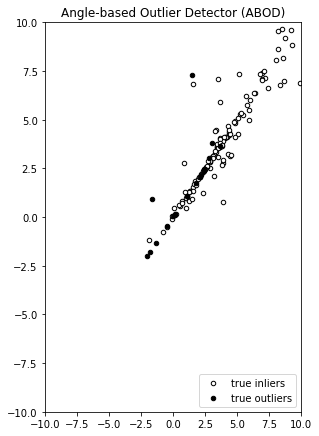

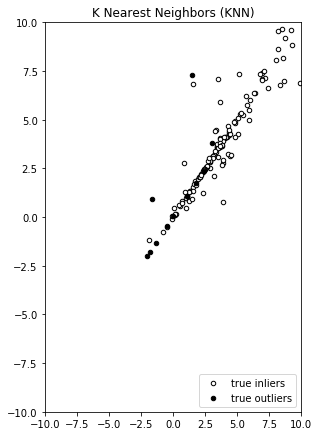

In [65]:
y_pred = np.zeros((len(input_matrix), 2))
for i, (clf_name,clf) in enumerate(classifiers.items()) :
    # fit the dataset to the model
    clf.fit(input_matrix)

    # predict raw anomaly score
    scores_pred = clf.decision_function(input_matrix)*-1

    # prediction of a datapoint category outlier or inlier
    y_pred[:,i] = clf.predict(input_matrix)

    # no of outliers in prediction
    n_outliers = int(y_pred[:,i].sum())
    print('No of Outliers : ',clf_name, n_outliers)

    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 *outlier_fraction)

    fig = plt.figure(figsize=(8,6))
    subplot = plt.subplot(1, 2, i + 1)
    fig.tight_layout()
    # scatter plot of inliers with white dots
    a = subplot.scatter(input_matrix[:-n_outliers, 0], input_matrix[:-n_outliers, 1], c='white',s=20, edgecolor='k') 
    # scatter plot of outliers with black dots
    b = subplot.scatter(input_matrix[-n_outliers:, 0], input_matrix[-n_outliers:, 1], c='black',s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
        [a, b],
        ['true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')
    subplot.set_title(clf_name)
    subplot.set_xlim((-10, 10))
    subplot.set_ylim((-10, 10))
plt.show() 

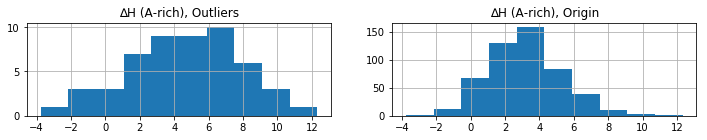

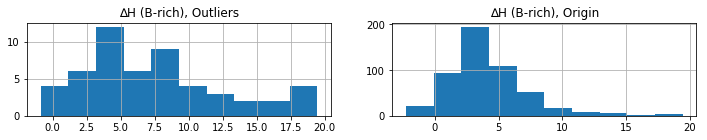

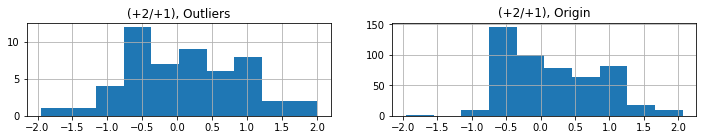

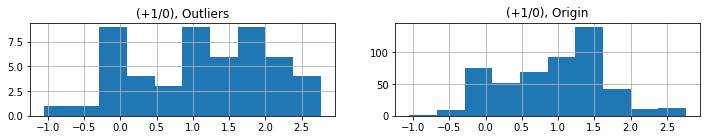

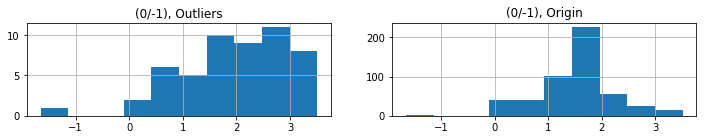

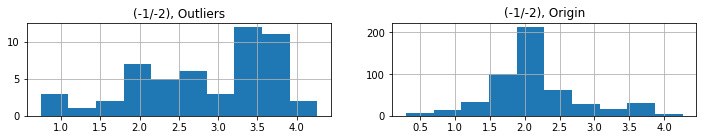

In [49]:
#ABOD
for i in range(len(descriptors)):
    plt.figure(figsize=(12,12))
    plt.subplot(6,2,1)
    data_1[y_pred[:,0]!=0][descriptors[i]].hist()
    plt.title(descriptors[i] + ', Outliers')
    plt.subplot(6,2,2)
    data_1[descriptors[i]].hist()
    plt.title(descriptors[i] + ', Origin')

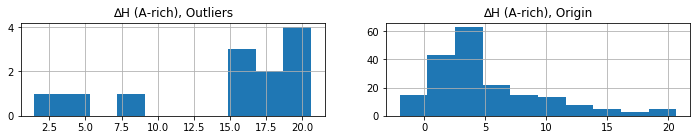

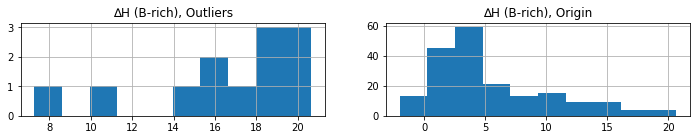

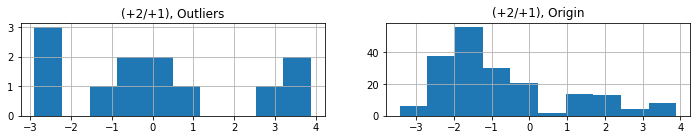

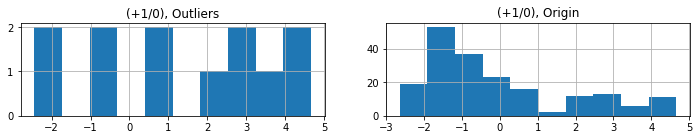

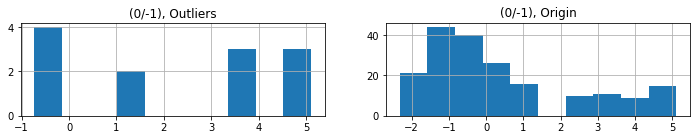

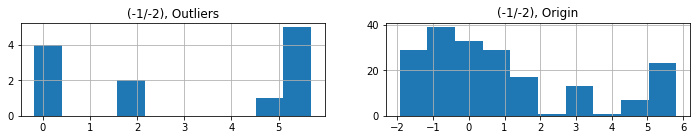

In [66]:
#KNN
for i in range(len(descriptors)):
    plt.figure(figsize=(12,12))
    plt.subplot(6,2,1)
    data_3[y_pred[:,1]!=0][descriptors[i]].hist()
    plt.title(descriptors[i] + ', Outliers')
    plt.subplot(6,2,2)
    data_3[descriptors[i]].hist()
    plt.title(descriptors[i] + ', Origin')

In [67]:
outlier_df_KNN = data_3[y_pred[:,1]!=0]
outlier_df_KNN.to_csv(r'\Users\xiang\Desktop\AI semiconductor\ai_semiconductors\ai_semiconductors\outlier_KNN_IV_IV.csv')

In [68]:
pd.DataFrame(outlier_df_KNN)

,Type,AB,Site,Impurity,∆H (A-rich),∆H (B-rich),(+2/+1),(+1/0),(0/-1),(-1/-2),...,Therm_cond,Elec_cond,Heat_fusion,Heat_vap,Electronegativity,At_num,Period,Group,Valence,Ox_state
0,IV-IV,SiC,M_i_A,In,15.963,15.963,3.891,4.660,5.109,5.629,...,81.60,3.4,3.26,226.34,1.78,49,5,13,3,3
1,IV-IV,SiC,M_i_B,La,19.972,19.554,3.863,4.539,4.991,5.556,...,13.50,1.9,11.30,399.57,1.10,57,6,3,3,3
20,IV-IV,C,M_A,Te,20.361,20.365,2.655,3.755,4.639,5.689,...,2.35,0.0,17.49,50.63,2.10,52,5,16,6,4
31,IV-IV,C,M_i_A,Co,18.489,18.489,-0.858,2.935,3.583,5.417,...,100.00,17.9,16.19,373.30,1.88,27,4,9,3,2
41,IV-IV,C,M_A,Br,18.301,18.305,1.045,2.637,3.932,5.081,...,0.12,0.0,5.29,14.72,2.96,35,4,17,7,1
72,IV-IV,C,M_i_neut,P,20.642,20.642,-0.409,2.183,3.901,5.652,...,0.23,0.0,0.63,12.40,2.19,15,3,15,5,5
403,IV-IV,GeC,M_i_A,Sb,16.708,17.620,0.455,0.878,1.199,1.666,...,24.30,2.6,19.83,67.97,2.05,51,5,15,5,3
465,IV-IV,GeC,M_i_neut,Pb,16.563,16.632,-0.008,0.645,1.138,1.641,...,35.30,4.8,4.77,177.90,2.33,82,6,14,4,2
745,IV-IV,SnC,M_B,Ba,20.062,18.292,-1.062,-0.809,-0.528,-0.177,...,18.40,2.8,8.01,140.20,0.89,56,6,2,2,2
758,IV-IV,SnC,M_i_neut,Na,7.884,14.781,-2.645,-0.970,-0.351,-0.011,...,141.00,20.1,2.60,98.01,0.93,11,3,1,1,1


In [273]:
outlier_df_ABOD = data[y_pred[:,0]!=0]
outlier_df_ABOD.to_csv(r'\Users\xiang\Desktop\AI semiconductor\ai_semiconductors\ai_semiconductors\outlier_df_ABOD.csv')

In [274]:
np.intersect1d(data[y_pred[:,0]!=0].index,data[y_pred[:,1]!=0].index), len(np.intersect1d(data[y_pred[:,0]!=0].index,data[y_pred[:,1]!=0].index))

(array([  0,   1,   6,   8,  10,  14,  15,  18,  20,  21,  26,  27,  41,
         45,  72, 332, 403, 404, 465, 480, 688, 723, 745, 782, 789, 837],
       dtype=int64), 26)